## Road Network DFD

Logan Gall, gall0487

Attributions/Assistance:
Laure Briol,
Gregory Kohler,
ESRI Arcpy documentation,
ChatGPT,
LucidChart

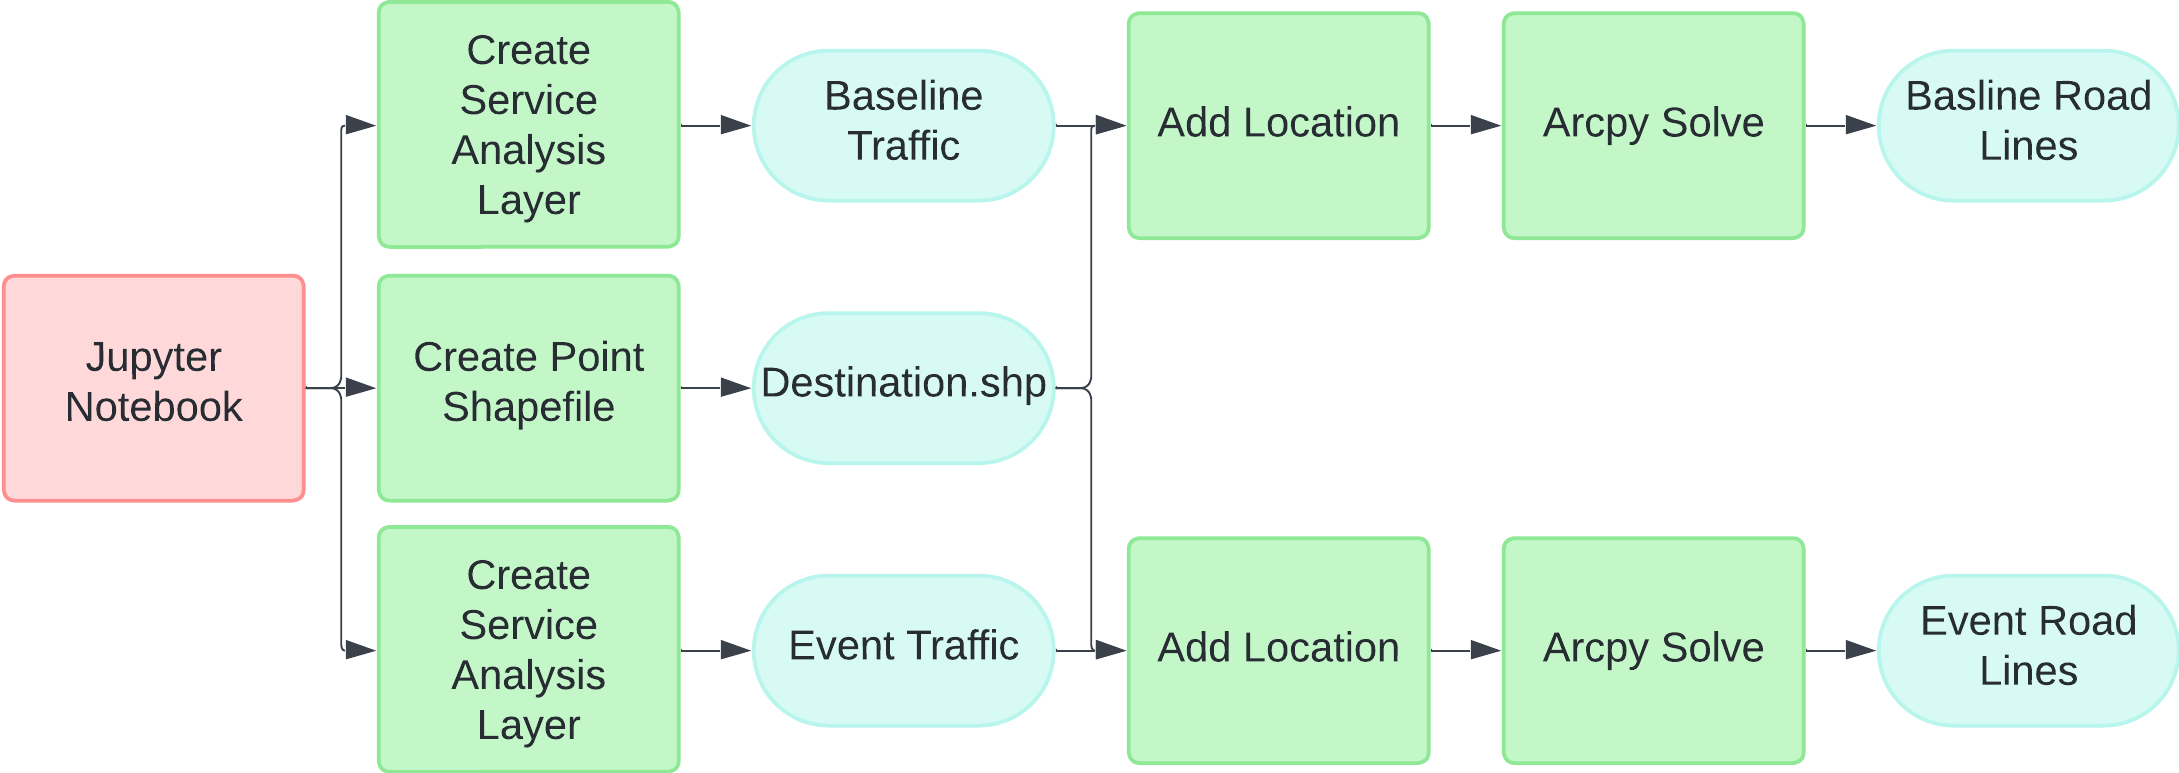

In [6]:
import arcpy
import os

#location to current directory
file_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath)
os.chdir(file_path)
#absolute Path for geodatabase
arcpy.env.workspace = file_path

In [7]:
#Define the location we want to travel to/from given the events.

#Coordinate intersection of Oak St and Washington Ave (longitude, latitude)
facility_coords = (-93.2265955, 44.9754918)

# Name of the new shapefile
shapefile_name = "Stadium_Village.shp"

# Spatial reference (can be an EPSG code, a full path to a PRJ file, or an arcpy.SpatialReference object)
# Example: WGS 1984
spatial_ref = arcpy.SpatialReference(4326)

# Create the point shapefile
dest_point = arcpy.CreateFeatureclass_management(arcpy.env.workspace, shapefile_name, "POINT", spatial_reference=spatial_ref)

# Create a new insert cursor for adding features to the shapefile
with arcpy.da.InsertCursor(shapefile_name, ["SHAPE@XY"]) as cursor:
    # Add the facility point
    cursor.insertRow([facility_coords])

In [8]:
#Make 2 Service Area Analysis Layers

#Analysis layer 1: No Traffic Baseline (Wednesday, July 12, 2023 at 3:00am)
##Output: Traffic analysis layer lines
no_traffic_layer = arcpy.na.MakeServiceAreaAnalysisLayer(
    network_data_source="https://www.arcgis.com/",
    layer_name="No Traffic Baseline",
    travel_mode="Driving Time",
    travel_direction="TO_FACILITIES",
    cutoffs=[10],
    time_of_day="7/12/2023 3:00:00 AM",
    time_zone="LOCAL_TIME_AT_LOCATIONS",
    output_type="LINES",
    polygon_detail="STANDARD",
    geometry_at_overlaps="OVERLAP",
    geometry_at_cutoffs="RINGS",
    polygon_trim_distance="100 Meters",
    exclude_sources_from_polygon_generation=None,
    accumulate_attributes=None,
    ignore_invalid_locations="SKIP"
)


#Adding destination location to the layer
arcpy.na.AddLocations(
    in_network_analysis_layer=no_traffic_layer,
    sub_layer="Facilities",
    in_table=dest_point,
    field_mappings="Name # #;CurbApproach # 0;Attr_Minutes # 0;Attr_TravelTime # 0;Attr_Miles # 0;Attr_Kilometers # 0;Attr_TimeAt1KPH # 0;Attr_WalkTime # 0;Attr_TruckMinutes # 0;Attr_TruckTravelTime # 0;Breaks_Minutes # #;Breaks_TravelTime # #;Breaks_Miles # #;Breaks_Kilometers # #;Breaks_TimeAt1KPH # #;Breaks_WalkTime # #;Breaks_TruckMinutes # #;Breaks_TruckTravelTime # #",
    search_tolerance="20000 Meters",
    sort_field=None,
    search_criteria="main.Routing_Streets SHAPE",
    match_type="MATCH_TO_CLOSEST",
    append="APPEND",
    snap_to_position_along_network="NO_SNAP",
    snap_offset="5 Meters",
    exclude_restricted_elements="EXCLUDE",
    search_query=None,
    allow_auto_relocate="ALLOW"
)

<Result 'No Traffic Baseline'>

In [9]:
#Analysis layer 2: Traffic event (Ex. October 27, 2023 7:45pm; Gopher Hockey VS Badgers)
event_time = "10/27/2023 7:45:00 PM"
name_event = "Large Event"

traffic_layer = arcpy.na.MakeServiceAreaAnalysisLayer(
    network_data_source="https://www.arcgis.com/",
    layer_name=name_event,
    travel_mode="Driving Time",
    travel_direction="TO_FACILITIES",
    cutoffs=[10],
    time_of_day=event_time,
    time_zone="LOCAL_TIME_AT_LOCATIONS",
    output_type="LINES",
    polygon_detail="STANDARD",
    geometry_at_overlaps="OVERLAP",
    geometry_at_cutoffs="RINGS",
    polygon_trim_distance="100 Meters",
    exclude_sources_from_polygon_generation=None,
    accumulate_attributes=None,
    ignore_invalid_locations="SKIP"
)


#Adding destination location to the layer
arcpy.na.AddLocations(
    in_network_analysis_layer=traffic_layer,
    sub_layer="Facilities",
    in_table=dest_point,
    field_mappings="Name # #;CurbApproach # 0;Attr_Minutes # 0;Attr_TravelTime # 0;Attr_Miles # 0;Attr_Kilometers # 0;Attr_TimeAt1KPH # 0;Attr_WalkTime # 0;Attr_TruckMinutes # 0;Attr_TruckTravelTime # 0;Breaks_Minutes # #;Breaks_TravelTime # #;Breaks_Miles # #;Breaks_Kilometers # #;Breaks_TimeAt1KPH # #;Breaks_WalkTime # #;Breaks_TruckMinutes # #;Breaks_TruckTravelTime # #",
    search_tolerance="20000 Meters",
    sort_field=None,
    search_criteria="main.Routing_Streets SHAPE",
    match_type="MATCH_TO_CLOSEST",
    append="APPEND",
    snap_to_position_along_network="NO_SNAP",
    snap_offset="5 Meters",
    exclude_restricted_elements="EXCLUDE",
    search_query=None,
    allow_auto_relocate="ALLOW"
)

<Result 'Large Event'>

In [10]:
#Solve the network dataset
##THIS COSTS ESRI CREDITS
solved_no_traffic = arcpy.na.Solve(no_traffic_layer)

In [11]:
#Solve the network dataset
##THIS COSTS ESRI CREDITS
solved_traffic = arcpy.na.Solve(traffic_layer)

In [12]:
# Extract the Service Area Polygons sublayer
no_traffic_sublayer = no_traffic_layer.getOutput(0)
no_traffic_sublayer = arcpy.na.GetNASublayer(no_traffic_sublayer, "SALines")

# Export the service area polygons to a new shapefile
output_shapefile = "no_traffic_lines.shp"
arcpy.management.CopyFeatures(no_traffic_sublayer, output_shapefile)

<Result 'C:\\Users\\Logan\\Documents\\ArcGIS\\Projects\\MyProject3\\no_traffic_lines.shp'>

In [13]:
# Extract the Service Area Polygons sublayer
traffic_sublayer = no_traffic_layer.getOutput(0)
traffic_sublayer = arcpy.na.GetNASublayer(traffic_sublayer, "SALines")

# Export the service area polygons to a new shapefile
output_shapefile = "traffic_lines.shp"
arcpy.management.CopyFeatures(traffic_sublayer, output_shapefile)

<Result 'C:\\Users\\Logan\\Documents\\ArcGIS\\Projects\\MyProject3\\traffic_lines.shp'>

## Roads QAQC

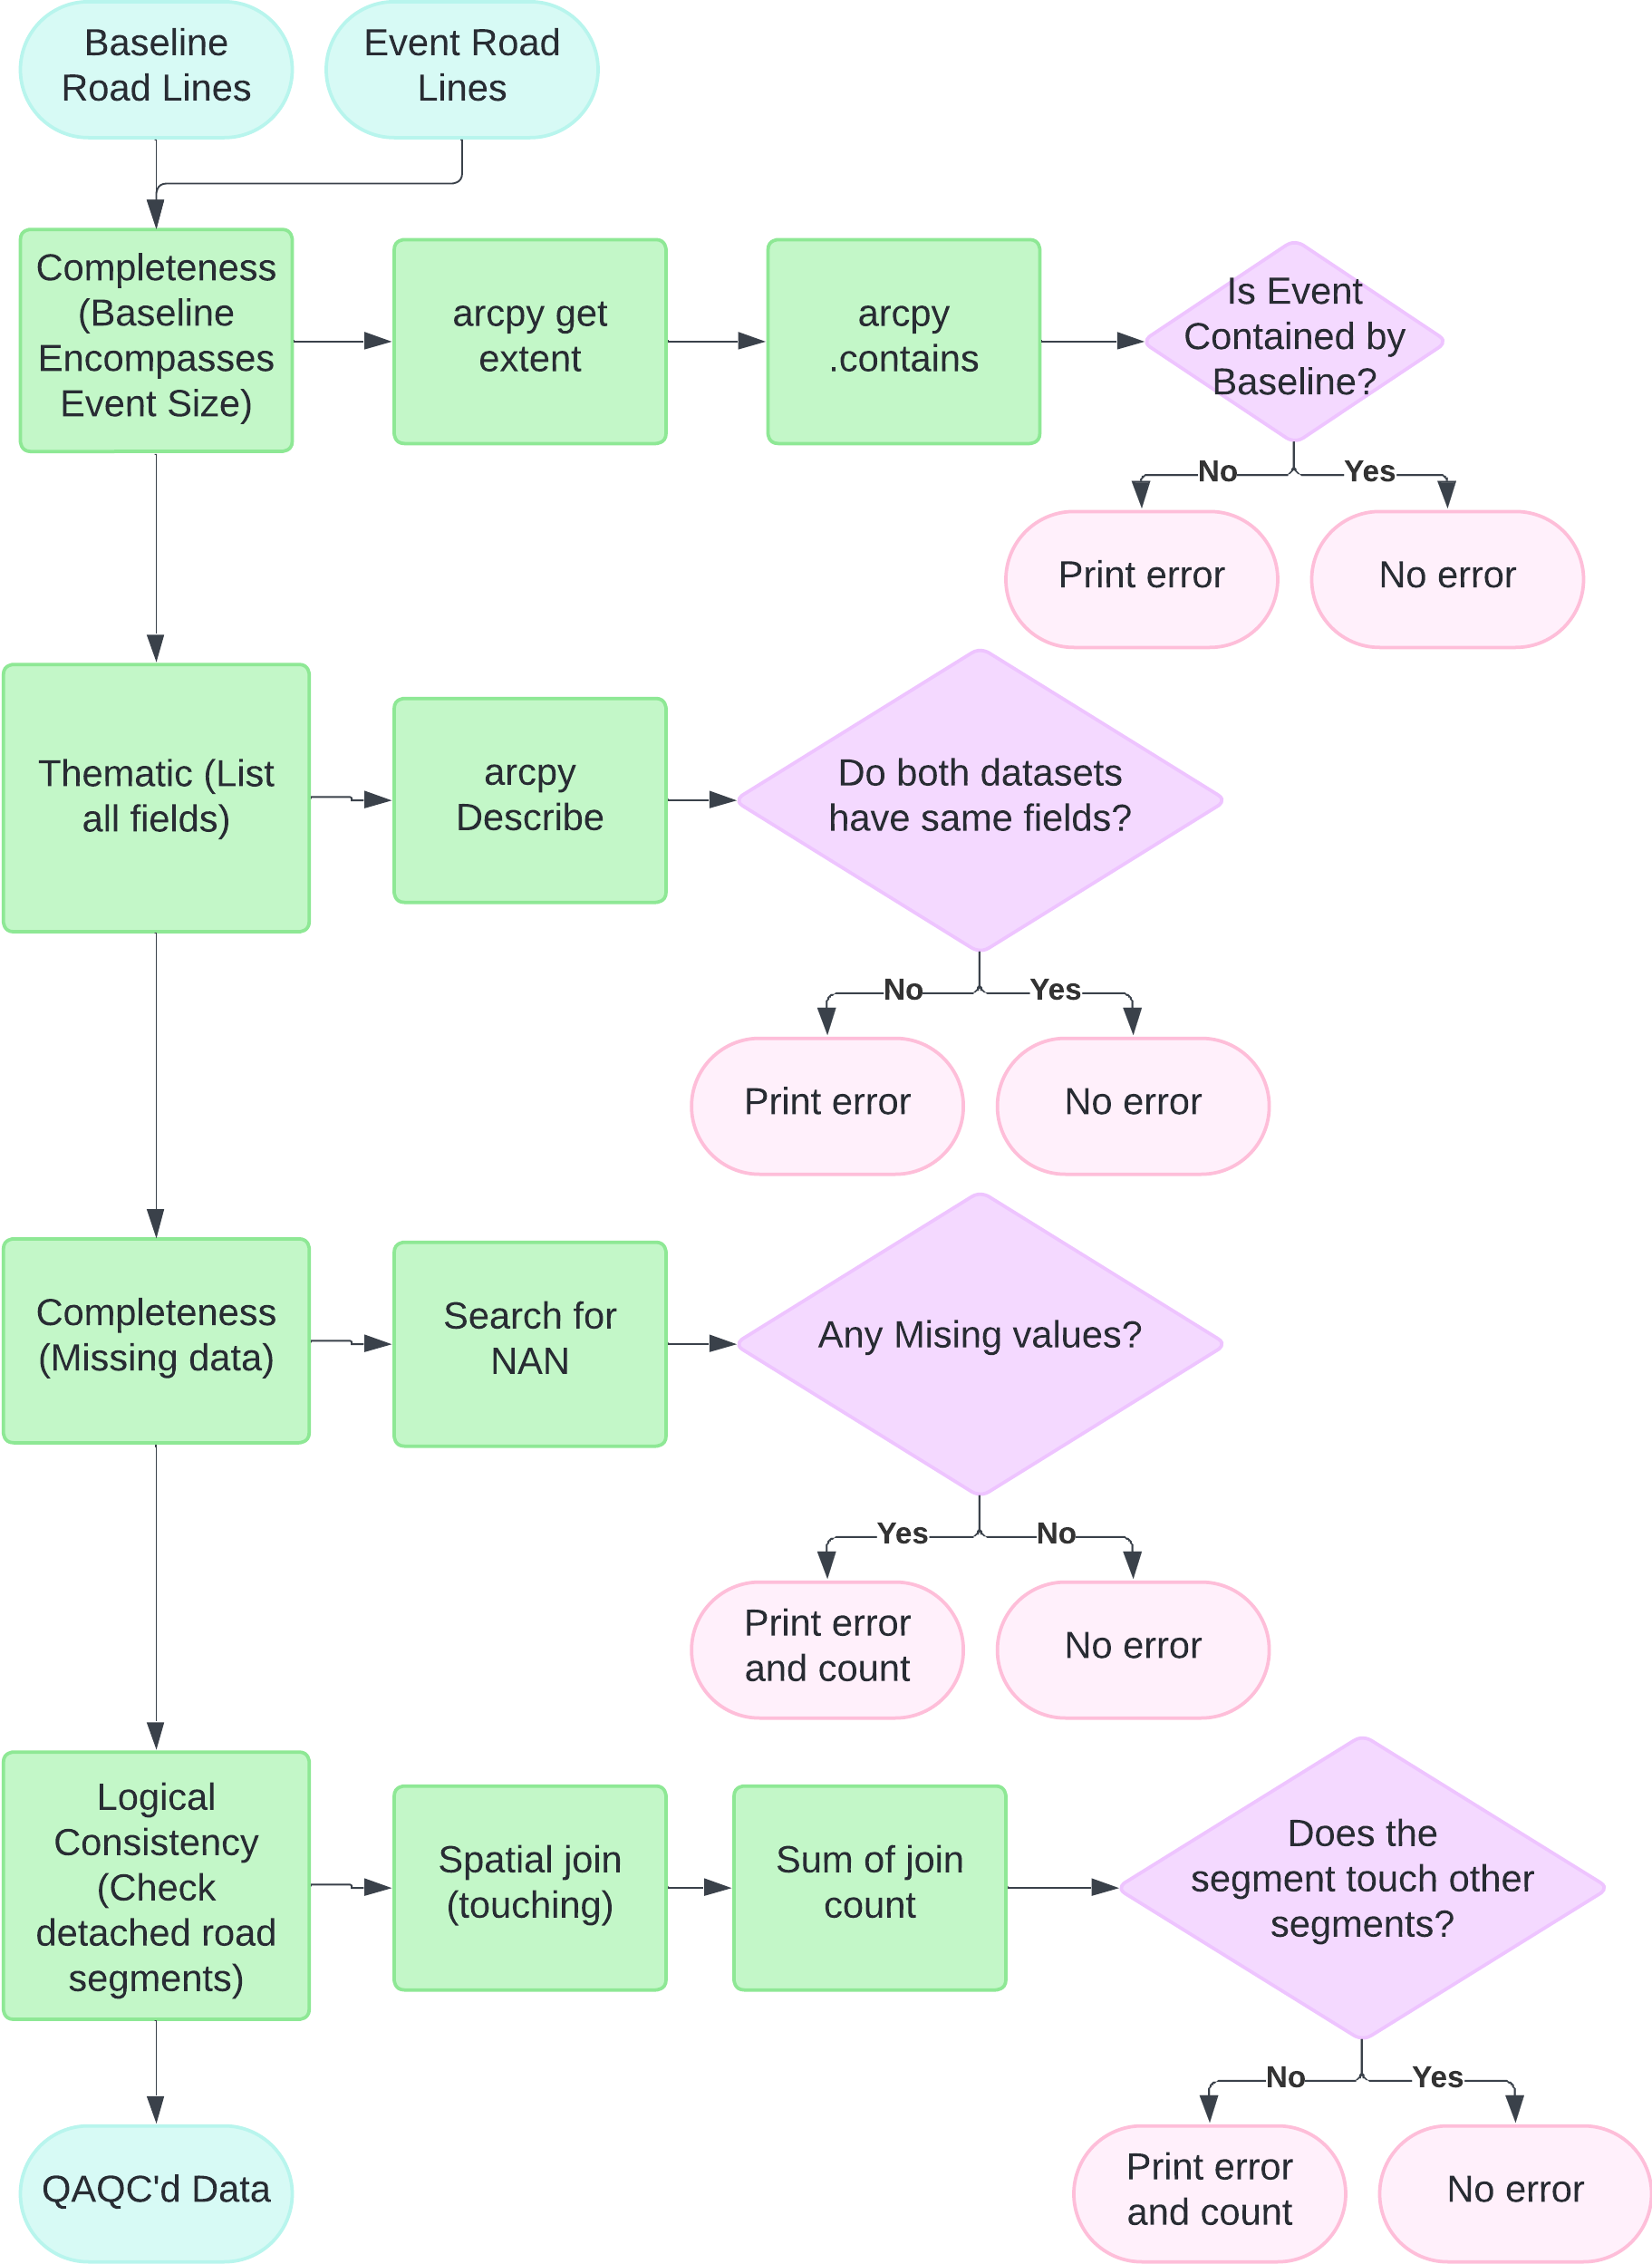

In [14]:
#ROAD NETWORK QAQC

#Data variables
baseline_dataset = no_traffic_sublayer
event_dataset = traffic_sublayer


#Completeness/Logical Consistency.
#Check if the baseline (no traffic) engulfs the event (traffic-filled) data. This ensures all the data can be compared between the two sets.

# Get the minimum bounding geometries (extent) of each dataset
baseline_extent = arcpy.Describe(baseline_dataset).extent
event_extent = arcpy.Describe(event_dataset).extent

# Check if baseline encompasses event data
encompasses = (baseline_extent.contains(event_extent))

if encompasses:
    print("Baseline extent is larger than traffic extent. Data is good.")
else:
    print("Baseline extent is smaller than traffic extent. Data is not good.")

Baseline extent is larger than traffic extent. Data is good.


In [15]:
# Get the list of fields for each dataset

#Thematic Check.
#Check if both datasets contain the same fields

# Use Describe to get dataset information
base_desc = arcpy.Describe(baseline_dataset)
event_desc = arcpy.Describe(event_dataset)

# List all field names from the dataset
base_field_names = [field.name for field in base_desc.fields]
event_field_names = [field.name for field in event_desc.fields]

# Compare the fields
same_columns = set(base_field_names) == set(event_field_names)

print(f"Do both datasets have the same columns? {same_columns}")

Do both datasets have the same columns? True


In [16]:
#Logical consistency
#Check if any road segments are isolated (not touching any other segments)

#Create function for check
def check_for_isolated_segments(input_dataset):

    # Define the output dataset for the spatial join
    output_dataset = "temp_data.shp"

    #Perform spatial join
    arcpy.analysis.SpatialJoin(
    target_features=input_dataset,
    join_features=input_dataset,
    out_feature_class=output_dataset,
    join_operation="JOIN_ONE_TO_ONE",
    join_type="KEEP_ALL",
    match_option="INTERSECT",
    search_radius=None,
    distance_field_name=""
    )
    
    # Create an empty list to store the ObjectIDs of line segments with join_count < 1
    isolated_segments = []

    # Use SearchCursor to iterate through the table
    with arcpy.da.SearchCursor(output_dataset, ["OID@", "Join_Count"]) as cursor:
        for row in cursor:
            # Check if join_count is less than 1
            if row[1] < 1:
                # Print ObjectID of the line segment
                print(f"Line segment with ObjectID {row[0]} is isolated")
                # Add the ObjectID to the list
                isolated_segments.append(row[0])

    # Return list of isolated segment IDs
    return isolated_segments

# Check for isolated segments in both datasets
baseline_isolated_segments = check_for_isolated_segments(baseline_dataset)
print("Baseline Dataset Isolated Segments:", baseline_isolated_segments)

event_isolated_segments = check_for_isolated_segments(event_dataset)
print("Event Dataset Isolated Segments:", event_isolated_segments)

Baseline Dataset Isolated Segments: []
Event Dataset Isolated Segments: []


In [17]:
#Completeness
#check for NAN values in given fields

#Create function
def check_missing_values(dataset, fields):
    #empty dictionary to store missing values
    missing_values = {}
    #Iterate thru all fields we want to check
    for field in fields:
        #Search through the dataset
        with arcpy.da.SearchCursor(dataset, [field]) as cursor:
            for row in cursor:
                #If there is an error, add it to the dictionary
                if row[0] is None:
                    #If there has not been an error in this field yet, add the field
                    if field not in missing_values:
                        missing_values[field] = 1
                    else:
                        missing_values[field] += 1
    #Check if dictionary is empty                    
    if not missing_values:
        return "No missing values found."
    else:
        return f"Missing values: {missing_values}"

fields_to_check = ["FromCumul_TravelTime", "FromCumul_Kilometers", "ToCumul_TravelTime", "ToCumul_Kilometers"]

# Check for both datasets
print("No Traffic Baseline:", check_missing_values(baseline_dataset, fields_to_check))
print("Large Event:", check_missing_values(event_dataset, fields_to_check))

No Traffic Baseline: No missing values found.
Large Event: No missing values found.
